# Problem:

Named Entity Recognition (NER) is a fundamental NLP task that involves identifying and classifying named entities in text into predefined categories such as person names, organizations, locations, dates, etc. This is crucial for information extraction, question answering, and knowledge base population. However, achieving high accuracy in NER can be challenging due to the complexities of language, such as ambiguity and variability in entity expressions

# Solution using BERT:

BERT (Bidirectional Encoder Representations from Transformers) has revolutionized many NLP tasks, including NER. Its ability to capture contextual information from both directions in a sentence makes it particularly well-suited for understanding the nuances of language and identifying entities accurately. By fine-tuning BERT on a specific NER dataset, we can leverage its powerful language representation capabilities to achieve state-of-the-art performance.

In this notebook, we demonstrate the practical application of BERT-base-uncased for NER using the CoNLL 2003 dataset. We fine-tune the pre-trained BERT model on this dataset and evaluate its performance in identifying and classifying named entities. This example showcases the effectiveness of BERT in tackling the challenges of NER and achieving high accuracy.

In [1]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=39efbf0352bb4f10dbdff13fe92a80e1e58d13065b9fc421088ff2ec0b8782e7
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


# Installing Libraries

In [2]:
from sklearn.model_selection import train_test_split
import datasets
import json
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification,
    Trainer,
    pipeline,
    TrainingArguments,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback,
)
import torch
import matplotlib.pyplot as plt
import numpy as np
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score

# Data Loading and Preprocessing

In [3]:
ds=load_dataset("conll2003", trust_remote_code=True)

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [5]:
print(ds["train"][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [6]:
print(ds['train'].features["ner_tags"])

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
label_list = ds["train"].features[f"ner_tags"].feature.names
label_encoding_dict = {label: i for i, label in enumerate(label_list)}

In [10]:
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [11]:
ds2=ds.map(preprocess_function, batched=True)
ds2

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [12]:
ds2['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0],
 'input_ids': [101,
  7327,
  19164,
  2446,
  2655,
  2000,
  17757,
  2329,
  12559,
  1012,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]}

# Model Fine-tuning

In [13]:
model = AutoModelForTokenClassification.from_pretrained(checkpoint, num_labels=len(label_list))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
args = TrainingArguments(
    output_dir = "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end = True,
    report_to = ["none"],
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
data_collator = DataCollatorForTokenClassification(tokenizer)
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]

    return {
        "accuracy_score": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

trainer = Trainer(
    model = model,
    args = args,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset = ds2["train"],
    eval_dataset = ds2["test"],
)

In [16]:
train_results = trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
1,0.054700,0.100437,0.977086,0.872047,0.895361,0.883550
2,0.037600,0.105521,0.979024,0.882669,0.901735,0.892100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

# Evaluation

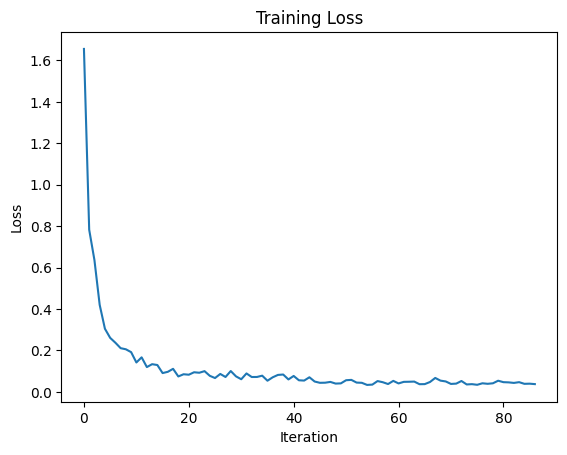

In [17]:
loss_values = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]

plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [18]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Evaluation results: {'eval_loss': 0.10043749213218689, 'eval_accuracy_score': 0.9770862495962097, 'eval_precision': 0.8720469046387308, 'eval_recall': 0.8953611898016998, 'eval_f1': 0.8835502751812702, 'eval_runtime': 10.4787, 'eval_samples_per_second': 329.524, 'eval_steps_per_second': 10.307, 'epoch': 2.0}


## Saving Model

In [19]:
trainer.save_model("our_ner_model") 

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [26]:
tokenizer.save_pretrained("our_ner_tokenizer")

('our_ner_tokenizer/tokenizer_config.json',
 'our_ner_tokenizer/special_tokens_map.json',
 'our_ner_tokenizer/vocab.txt',
 'our_ner_tokenizer/added_tokens.json',
 'our_ner_tokenizer/tokenizer.json')

In [20]:
id2label = {str(i): label for i, label in enumerate(label_list)}
label2id = {label: str(i) for i, label in enumerate(label_list)}

In [22]:
config = json.load(open("our_ner_model/config.json"))
config["id2label"] = id2label
config["label2id"] = label2id
json.dump(config, open("our_ner_model/config.json", "w"))

In [23]:
model_fine_tuned = AutoModelForTokenClassification.from_pretrained("our_ner_model")
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer, aggregation_strategy="simple", ignore_labels=[])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [25]:
sample = "The Eifell Tower became biggest that day."
res = nlp(sample)
print(res)

[{'entity_group': 'O', 'score': 0.9968047, 'word': 'the', 'start': 0, 'end': 3}, {'entity_group': 'LOC', 'score': 0.5710168, 'word': 'eife', 'start': 4, 'end': 8}, {'entity_group': 'ORG', 'score': 0.5701602, 'word': '##ll', 'start': 8, 'end': 10}, {'entity_group': 'LOC', 'score': 0.35918507, 'word': 'tower', 'start': 11, 'end': 16}, {'entity_group': 'O', 'score': 0.99922407, 'word': 'became biggest that day.', 'start': 17, 'end': 41}]


In [27]:
!zip -r our_ner_model.zip our_ner_model
!zip -r our_ner_tokenizer.zip our_ner_tokenizer

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: our_ner_model/ (stored 0%)
  adding: our_ner_model/training_args.bin (deflated 51%)
  adding: our_ner_model/tokenizer_config.json (deflated 76%)
  adding: our_ner_model/vocab.txt (deflated 53%)
  adding: our_ner_model/tokenizer.json (deflated 71%)
  adding: our_ner_model/config.json (deflated 48%)
  adding: our_ner_model/special_tokens_map.json (deflated 42%)
  adding: our_ner_model/model.safetensors (deflated 7%)
  adding: our_ner_tokenizer/ (stored 0%)
  adding: our_ner_tokenizer/tokenizer_config.json (deflated 76%)
  adding: our_ner_tokenizer/vocab.txt (deflated 53%)
  adding: our_ner_tokenizer/tokenizer.json (deflated 71%)
  adding: our_ner_tokenizer/special_tokens_map.json (deflated 42%)
